In [1]:
import word2vec as w2v
import pandas as pd
import numpy as np

In [2]:
trumpTweets_DF = pd.read_csv("realdonaldtrump.csv", sep=",")
trumpTweets_DF
tweetsContent = trumpTweets_DF["content"].to_numpy()
tweetsContent = tweetsContent[:10]

In [3]:
model = w2v.Word2Vec(tweetsContent[0], 5, 2, 3)

In [4]:
result, found_representations = model.train(0.1, 25, 0.1, False)

Processing:   8% --- accuracy in current step: -107.60265
Processing:  16% --- accuracy in current step: -106.73774
Processing:  24% --- accuracy in current step: -106.11405
Processing:  32% --- accuracy in current step: -105.74494
Processing:  40% --- accuracy in current step: -105.64452
Processing:  48% --- accuracy in current step: -105.77013
Processing:  56% --- accuracy in current step: -106.04235
Processing:  64% --- accuracy in current step: -106.36763
Processing:  72% --- accuracy in current step: -106.66134
Processing:  80% --- accuracy in current step: -106.86703
Processing:  88% --- accuracy in current step: -106.96589
Processing:  96% --- accuracy in current step: -106.97328


In [5]:
print([rep[1] for rep in found_representations])
# w2v.plot()

[-104.55242599090548, -104.62927985486016, -104.78953806144051, -105.05121773978901, -105.25234445862887, -105.64452494743772, -105.74494149961237, -105.75371810122287, -105.77012950284798, -105.84623114102862, -106.04234941097286, -106.11404994963291, -106.36762550059399, -106.49381931083967, -106.66134412949472, -106.70847956850986, -106.73773961090396, -106.86703361303255, -106.96589074201555, -106.97328136604257, -107.14339367987942, -107.60265112547067, -107.767598162681, -108.35349813864575, -108.89111567192765]


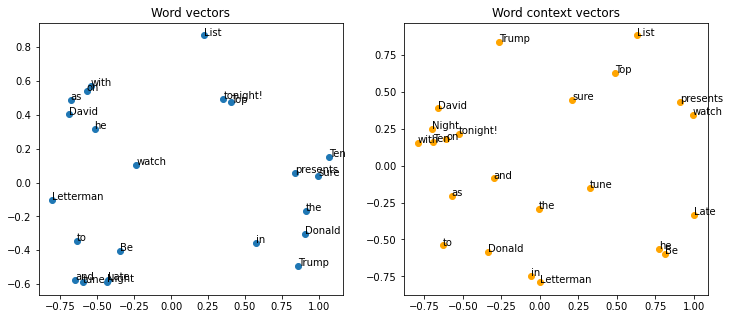

In [6]:
w2v.plot(result, context=True)